In [159]:
from collections import defaultdict
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn import metrics
from collections import Counter
from nltk.corpus import stopwords
import spacy
from spacy import displacy # see if we need that
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
# nltk.download('stopwords')
sns.set()


Import data set:


In [160]:
pd.options.mode.chained_assignment = None

col_list = ['text', 'class']
df_full = pd.read_csv('data/data_set.csv', usecols=col_list)
df = df_full[['text']]

df["text"] = df["text"].astype(str)
df_full.head()
df.head()


,text
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


# Text preprocessing:


## lower casing:


In [161]:

df["text_lower"] = df["text"].str.lower()
df.head()
# drop the new column created in last cell
# df.drop(["text_lower"], axis=1, inplace=True)


,text,text_lower
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


## remove punctuation


In [162]:
punctuation = '«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'
PUNCT_TO_REMOVE = punctuation


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


df["text_wo_punct"] = df["text_lower"].apply(
    lambda text: remove_punctuation(text))
df.head()


,text,text_lower,text_wo_punct
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...


## remove stopwords:


In [163]:
STOPWORDS_GREEK = set(stopwords.words('greek'))


def import_additional_greek_stopwords(STOPWORDS_GREEK):
    STOPWORDS_GREEK.add('της')
    STOPWORDS_GREEK.add('από')
    STOPWORDS_GREEK.add('είναι')
    STOPWORDS_GREEK.add('έχει')
    STOPWORDS_GREEK.add('σας')
    STOPWORDS_GREEK.add('τους')
    STOPWORDS_GREEK.add('τη')
    STOPWORDS_GREEK.add('μας')
    STOPWORDS_GREEK.add('στα')
    STOPWORDS_GREEK.add('στις')
    STOPWORDS_GREEK.add('στους')
    STOPWORDS_GREEK.add('μου')
    STOPWORDS_GREEK.add('σου')
    return STOPWORDS_GREEK


STOPWORDS_GREEK = import_additional_greek_stopwords(STOPWORDS_GREEK)


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS_GREEK])


df["text_wo_stop"] = df["text_wo_punct"].apply(
    lambda text: remove_stopwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...,ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...,άλλο άκρο έχουν περάσει πλέον διαδηλώσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...,λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...,25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...,μία εβδομάδα αρχική εκτίμηση ότι μαντλίν μακκα...


## remove intonation:


In [164]:
def remove_intonation(text):

    rep = {"ά": "α", "έ": "ε", "ή": "η", "ί": "ι", "ό": "ο", "ύ": "υ", "ώ": "ω", "ϊ": "ι",
           "ἀ": "α", "ἐ": "ε", "ἤ": "η", "ἰ": "ι", "ἄ": "α", "ὐ": "υ", "ὡ": "ω", "ὦ": "ω",
           'ὖ': 'υ', 'ὅ': 'ο', 'ῆ': 'η', 'ῇ': 'η', 'ῦ': 'υ', 'ὁ': 'ο', 'ὑ': 'υ', 'ὲ': 'ε',
           'ὺ': 'υ', 'ἂ': 'α', 'ἵ': 'ι', 'ὴ': 'η', 'ὰ': 'α', 'ἅ': 'α', 'ὶ': 'ι', 'ἴ': 'ι',
           'ὸ': 'ο', 'ἥ': 'η', 'ἡ': 'η', 'ὕ': 'υ', 'ἔ': 'ε', 'ἳ': 'ι', 'ὗ': 'υ', 'ἃ': 'α',
           'ὃ': 'ο', 'ὥ': 'ω', 'ὔ': 'υ', 'ῖ': 'ι', 'ἣ': 'η', 'ἷ': 'ι', 'ἑ': 'ε', 'ᾧ': 'ω',
           'ἢ': 'η', 'ΐ': 'ι', }

    rep = dict((nltk.re.escape(k), v) for k, v in rep.items())
    pattern = nltk.re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[nltk.re.escape(m.group(0))], text)

    return text


df["text_wo_intonation"] = df["text_wo_stop"].apply(
    lambda text: remove_intonation(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop,text_wo_intonation
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...,ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...,άλλο άκρο έχουν περάσει πλέον διαδηλώσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...,λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...,25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...,μία εβδομάδα αρχική εκτίμηση ότι μαντλίν μακκα...,μια εβδομαδα αρχικη εκτιμηση οτι μαντλιν μακκα...


## remove frequent words:


### get most frequent words:


In [165]:
cnt = Counter()
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten more frequent elements:
cnt.most_common(10)


[('οτι', 1574),
 ('ειχε', 912),
 ('ηταν', 726),
 ('μια', 705),
 ('συμφωνα', 552),
 ('δυο', 544),
 ('οπως', 526),
 ('ενω', 515),
 ('ενα', 497),
 ('αλλα', 496)]

### remove most frequent words:


In [166]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])


def remove_freqwords(text):
    """custom function to remove frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])


df["text_wo_freq"] = df["text_wo_intonation"].apply(
    lambda text: remove_freqwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop,text_wo_intonation,text_wo_freq
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...,ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...,άλλο άκρο έχουν περάσει πλέον διαδηλώσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...,λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...,25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...,μία εβδομάδα αρχική εκτίμηση ότι μαντλίν μακκα...,μια εβδομαδα αρχικη εκτιμηση οτι μαντλιν μακκα...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...


## remove most rare words:


In [167]:
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten least frequent elements:
cnt.most_common()[:-10-1:-1]


[('νικι', 2),
 ('αναπαυσου', 2),
 ('ραγιζει', 2),
 ('αντζελα', 2),
 ('αξιζες', 2),
 ('γνωρισεις', 2),
 ('γλυκος', 2),
 ('αξιοπιστος', 2),
 ('σιμι', 2),
 ('μπαρκερ', 2)]

In [168]:
# Drop the two columns which are no longer needed
df.drop(["text_wo_punct", "text_wo_stop", "text_lower"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])


def remove_rarewords(text):
    """custom function to remove rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])


df["text_wo_rare"] = df["text_wo_freq"].apply(
    lambda text: remove_rarewords(text))
df.head()


,text,text_wo_intonation,text_wo_freq,text_wo_rare
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μια εβδομαδα αρχικη εκτιμηση οτι μαντλιν μακκα...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...


## Lemmatization:


In [169]:
# # Drop the columns which are no longer needed
# df.drop(["text_wo_intonation", "text_wo_freq"], axis=1, inplace=True)

# nlp = spacy.load("el_core_news_sm")
# # nlp.remove_pipe("tagger")

# def lemmatize_words(text):
#     """custom function to lemmatize text"""
#     doc = nlp(text)
#     # pos_tagged_text = text.pos
#     return " ".join([token.lemma_ for token in doc])


# df["text_lemmatized"] = df["text_wo_rare"].apply(
#     lambda text: lemmatize_words(text))
# df.head()


## Remove numbers:


In [170]:
# Drop the columns which are no longer needed
df.drop(["text_wo_intonation", "text_wo_freq"], axis=1, inplace=True)

def drop_numbers(text):
    text_wo_numbers = re.sub(r'[0-9]+', '', text)
    return text_wo_numbers


df["text_wo_numbers"] = df["text_wo_rare"].apply(
    lambda text: drop_numbers(text))
df.head()


,text,text_wo_rare,text_wo_numbers
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,χρονια θανατο ειρηνης λαγουδη μητερας τριων π...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...


## Remove single letter words:


In [171]:
def drop_single_letter_words(text):
    return ' '.join([w for w in text.split() if len(w) > 1])


df["text_wo_single_letters"] = df["text_wo_numbers"].apply(
    lambda text: drop_single_letter_words(text))
df.head()


,text,text_wo_rare,text_wo_numbers,text_wo_single_letters
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,χρονια θανατο ειρηνης λαγουδη μητερας τριων π...,χρονια θανατο ειρηνης λαγουδη μητερας τριων πα...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...


## Remove s in the end of every word ('ς'):

In [172]:
CHAR_TO_REMOVE = 'ς'

def remove_final_s(text):
    return re.sub('ς', '', text)

df["text_wo_final_s"] = df["text_wo_single_letters"].apply(
    lambda text: remove_final_s(text))
df.head()

,text,text_wo_rare,text_wo_numbers,text_wo_single_letters,text_wo_final_s
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσει ηπα δ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανο καταδικασμενο παιδοφιλο ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,χρονια θανατο ειρηνης λαγουδη μητερας τριων π...,χρονια θανατο ειρηνης λαγουδη μητερας τριων πα...,χρονια θανατο ειρηνη λαγουδη μητερα τριων παιδ...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...


## Add labels to the pre-processed df:


In [173]:
# Drop the columns which are no longer needed , "text_lemmatized"
df.drop(["text", "text_wo_rare", "text_wo_single_letters",
        "text_wo_numbers"], axis=1, inplace=True)

# Set up data set with preprocessed text & classes:
df['label'] = df_full['class']
df.columns = ['text', 'label']
df.head()


,text,label
0,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,Ανθρωποκτονία
1,αλλο ακρο εχουν περασει πλεον διαδηλωσει ηπα δ...,Ανθρωποκτονία
2,λεει κουβεντα γερμανο καταδικασμενο παιδοφιλο ...,Ανθρωποκτονία
3,χρονια θανατο ειρηνη λαγουδη μητερα τριων παιδ...,Ανθρωποκτονία
4,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,Ανθρωποκτονία


## Classification Analysis:


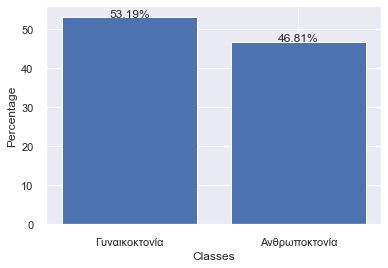

text     0
label    0
dtype: int64

In [174]:
label_distribution = (df['label'].value_counts() * 100) / len(df)

# Add value labels


def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], "%.2f" % round(y[i], 2) + "%", ha='center')


plt.bar(label_distribution.index, label_distribution)
add_labels(label_distribution.index, label_distribution)
plt.xlabel("Classes")
plt.ylabel("Percentage")
plt.show()

# See missing values:
df.isna().sum()


## Split data set to train, validate and test:


In [175]:
# df_train, df_test = model_selection.train_test_split(df, test_size=0.2, random_state=25)

# Split to train validate and test
df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [
                                          int(.6*len(df)), int(.8*len(df))])

print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")
print(f"No. of validating examples: {df_validate.shape[0]}")

# Get X_train, y_train, X_val, y_val, X_test, y_test

X_train = df_train['text']
y_train = df_train['label']

X_val = df_validate['text']
y_val = df_validate['label']

X_test = df_test['text']
y_test = df_test['label']


No. of training examples: 310
No. of testing examples: 104
No. of validating examples: 103


## N-gram analysis:

In [176]:

def generate_N_grams(text, ngram=1):
    """"custom function to generate n-grams"""
    words = [word for word in text.split(
        " ") if word not in set(STOPWORDS_GREEK)]
    print("Sentence after removing stopwords:", words)
    temp = zip(*[words[i:] for i in range(0, ngram)])
    ans = [' '.join(ngram) for ngram in temp]
    return ans


feminicide_values = defaultdict(int)
homicide_values = defaultdict(int)


# Get the count of every word in both the columns of df_train where label="Γυναικοκτονία"
for text in df_train[df_train.label == "Γυναικοκτονία"].text:
    for word in generate_N_grams(text,2):
        feminicide_values[word] += 1

# Get the count of every word in both the columns of df_train where label="Ανθρωποκτονία"
for text in df_train[df_train.label == "Ανθρωποκτονία"].text:
    for word in generate_N_grams(text,2):
        homicide_values[word] += 1


Sentence after removing stopwords: ['σχεδον', 'πεντε', 'γυναικε', 'εχασαν', 'ζωη', 'περυσι', 'γαλλια', 'δολοφονημενε', 'νυν', 'πρωην', 'συντροφο', 'καταθεσει', 'μηνυση', 'εναντιον', 'ασκηση', 'βια', 'στοιχεια', 'γυναικοκτονιε', 'δοθηκαν', 'δημοσιοτητα', 'γυναικοκτονιων', 'συνεβησαν', 'θυματα', 'ειχαν', 'ηδη', 'υποστει', 'βια', 'σωματικη', 'ψυχολογικη', 'σεξουαλικη', 'συντροφο', 'ερευνα', 'δημοσιοποιησε', 'υπουργειο', 'εσωτερικων', 'γαλλια', 'επιση', 'θυματων', 'ειχαν', 'καταθεσει', 'μηνυση', 'επειτα', 'γεγονοτα', 'γαλλο', 'υπουργο', 'εσωτερικων', 'ζεραρ', 'νταρμανεν', 'ανακοινωσε', 'προτεραιοτητα', 'επεξεργασια', 'μηνυσεων', 'ενδοοικογενειακη', 'βια', 'οριστει', 'αξιωματικο', 'ειδικευμενο', 'περιστατικα', 'καθε', 'αστυνομικο', 'τμημα', 'μοναδα', 'αριθμο', 'θανατων', 'ενδοοικογενειακη', 'βια', 'περυσι', 'γυναικε', 'ανδρε', 'πιο', 'χαμηλο', 'τελευταιων', 'ετων', 'επειτα', 'μαυρο', 'οποιο', 'καταγραφηκαν', 'γυναικοκτονιε', 'τριτο', 'δολοφονιων', 'ανεξαρτητω', 'φυλου', 'δραστη', 'εκανε', '

In [177]:
# focus on more frequently occuring words for every sentiment=>
# sort in DO wrt 2nd column in each of feminicide_values and homicide_values
df_feminicide = pd.DataFrame(
    sorted(feminicide_values.items(), key=lambda x: x[1], reverse=True))
df_homicide = pd.DataFrame(
    sorted(homicide_values.items(), key=lambda x: x[1], reverse=True))

fc1 = df_feminicide[0][:10]
fc2 = df_feminicide[1][:10]

hc1 = df_homicide[0][:10]
hc2 = df_homicide[1][:10]


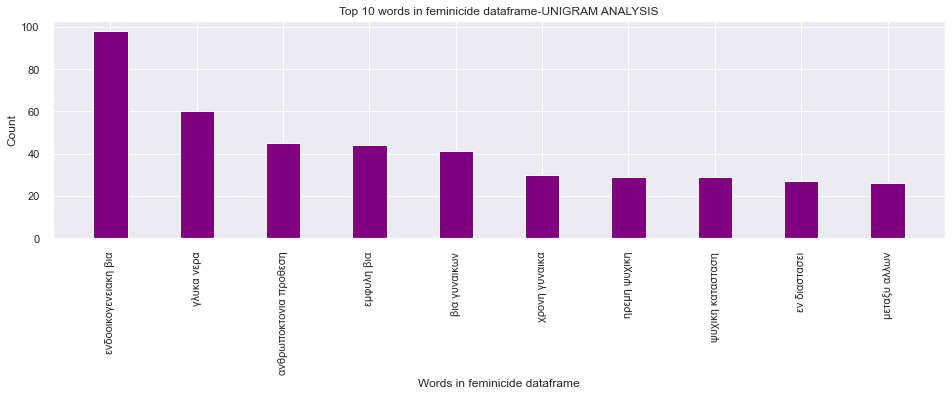

In [178]:
plt.figure(1, figsize=(16, 4))
plt.bar(fc1, fc2, color='purple',
        width=0.4)
plt.xlabel("Words in feminicide dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 words in feminicide dataframe-UNIGRAM ANALYSIS")
# plt.savefig("feminicide-unigram.png")
plt.show()


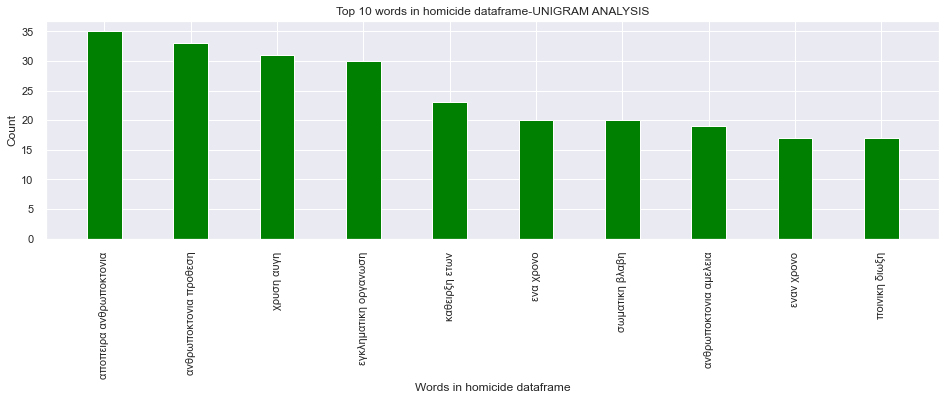

In [179]:
plt.figure(1, figsize=(16, 4))
plt.bar(hc1, hc2, color='green',
        width=0.4)
plt.xlabel("Words in homicide dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 words in homicide dataframe-UNIGRAM ANALYSIS")
# plt.savefig("homicide-unigram.png")
plt.show()


## TfIdfVectorizer:


In [180]:
vectorizer = TfidfVectorizer()

# remember to use the original X_train set
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape


(310, 14539)

<font color=green>This shows that training set is comprised of 310 documents, and 14539 features.</font>


## Build some Pipelines:


### Naive Bayes:


               precision    recall  f1-score   support

Ανθρωποκτονία       1.00      0.61      0.76        57
Γυναικοκτονία       0.68      1.00      0.81        46

     accuracy                           0.79       103
    macro avg       0.84      0.81      0.78       103
 weighted avg       0.86      0.79      0.78       103



<AxesSubplot:>

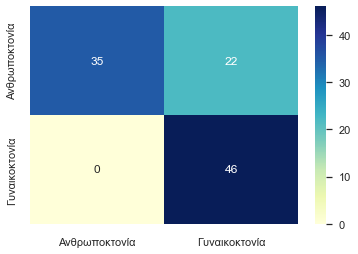

In [181]:
text_clf_NB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf_NB.fit(X_train, y_train)

predicted = text_clf_NB.predict(X_val)
np.mean(predicted == y_val)

print(metrics.classification_report(y_val, predicted))

# Confusion Matrix:
cfmtx_NB = pd.DataFrame(metrics.confusion_matrix(y_val, predicted), index=[
    'Ανθρωποκτονία', 'Γυναικοκτονία'], columns=['Ανθρωποκτονία', 'Γυναικοκτονία'])

cfmtx_NB

sns.heatmap(cfmtx_NB, annot=True, fmt='d', cmap='YlGnBu')


### Linear Support Vector Machines:


               precision    recall  f1-score   support

Ανθρωποκτονία       0.93      0.93      0.93        57
Γυναικοκτονία       0.91      0.91      0.91        46

     accuracy                           0.92       103
    macro avg       0.92      0.92      0.92       103
 weighted avg       0.92      0.92      0.92       103



<AxesSubplot:>

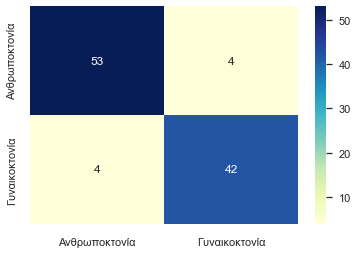

In [182]:
text_clf_SVM = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf_SVM.fit(X_train, y_train)

predicted = text_clf_SVM.predict(X_val)
np.mean(predicted == y_val)

print(metrics.classification_report(y_val, predicted))

# Confusion Matrix:
cfmtx_SVM = pd.DataFrame(metrics.confusion_matrix(y_val, predicted), index=[
    'Ανθρωποκτονία', 'Γυναικοκτονία'], columns=['Ανθρωποκτονία', 'Γυναικοκτονία'])

cfmtx_SVM

sns.heatmap(cfmtx_SVM, annot=True, fmt='d', cmap='YlGnBu')
